In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 1. Load cleaned master data
df = pd.read_csv('master_crypto_daily_prices.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# 2. Feature engineering
df['Daily change']   = df.groupby('Ticker')['Close'].diff()
df['Daily % change'] = df['Daily change'] / df.groupby('Ticker')['Close'].shift(1) * 100
df['Price range']    = df['High'] - df['Low']
df['Average price']  = (df['High'] + df['Low']) / 2
df['7d ma']          = df.groupby('Ticker')['Close'] \
                          .transform(lambda x: x.rolling(7).mean())
df['7d volatility'] = df.groupby('Ticker')['Close'] \
                          .transform(lambda x: x.pct_change().rolling(7).std() * 100)

# 3. Round all numeric columns to 4 decimal places
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].round(4)

# (Optional) Save expanded & rounded dataset
df.to_csv('crypto_features.csv', index=False)

print(f"Feature engineering complete — dataset now has {df.shape[1]} columns, all numerics rounded to 4 decimals.")

Feature engineering complete — dataset now has 12 columns, all numerics rounded to 4 decimals.


## Question 1: Price Trend Over Time
How has the daily closing price evolved from the dataset’s start date to today?

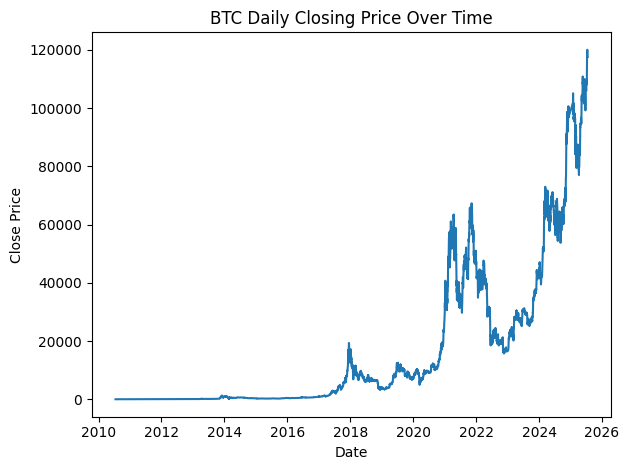

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature-engineered dataset
df = pd.read_csv('master_crypto_daily_prices.csv', parse_dates=['Date'])

# Filter for a single ticker (e.g., Bitcoin, 'BTC')
ticker = 'BTC'
if 'Ticker' in df.columns:
    df_ticker = df[df['Ticker'] == ticker]
else:
    df_ticker = df

# Plot daily closing price over time
plt.figure()
plt.plot(df_ticker['Date'], df_ticker['Close'])
plt.title(f'{ticker} Daily Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.tight_layout()
plt.show()

## Question 2: Rolling Volatility Dynamics  
How has 7‑day rolling volatility evolved, and where are the biggest spikes?

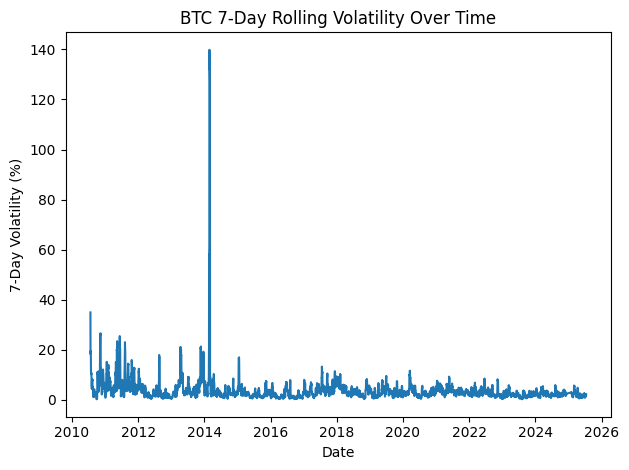

In [11]:
# Load the feature‐engineered dataset (with your six new columns)
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])

# Filter for BTC
df_btc = df[df['Ticker']=='BTC']

plt.figure()
plt.plot(df_btc['Date'], df_btc['7d volatility'])
plt.title('BTC 7‑Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('7‑Day Volatility (%)')
plt.tight_layout()
plt.show()

## Question 3: Return Distribution  
What does the distribution of daily returns look like, and how heavy‑tailed is Bitcoin’s return series?

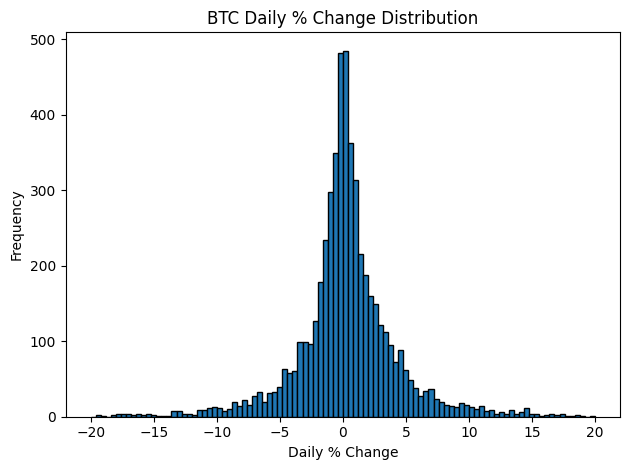

In [12]:
import matplotlib.pyplot as plt

# Load the feature‐engineered data if you haven’t already
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df_btc = df[df['Ticker']=='BTC'].dropna(subset=['Daily % change'])

plt.figure()
plt.hist(df_btc['Daily % change'], bins=100, range=(-20, 20), edgecolor='black')
plt.title('BTC Daily % Change Distribution')
plt.xlabel('Daily % Change')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Question 4: Moving‑Average Crossovers  
How often do the 7‑day and 30‑day moving averages cross, and do these crossings precede significant price moves?

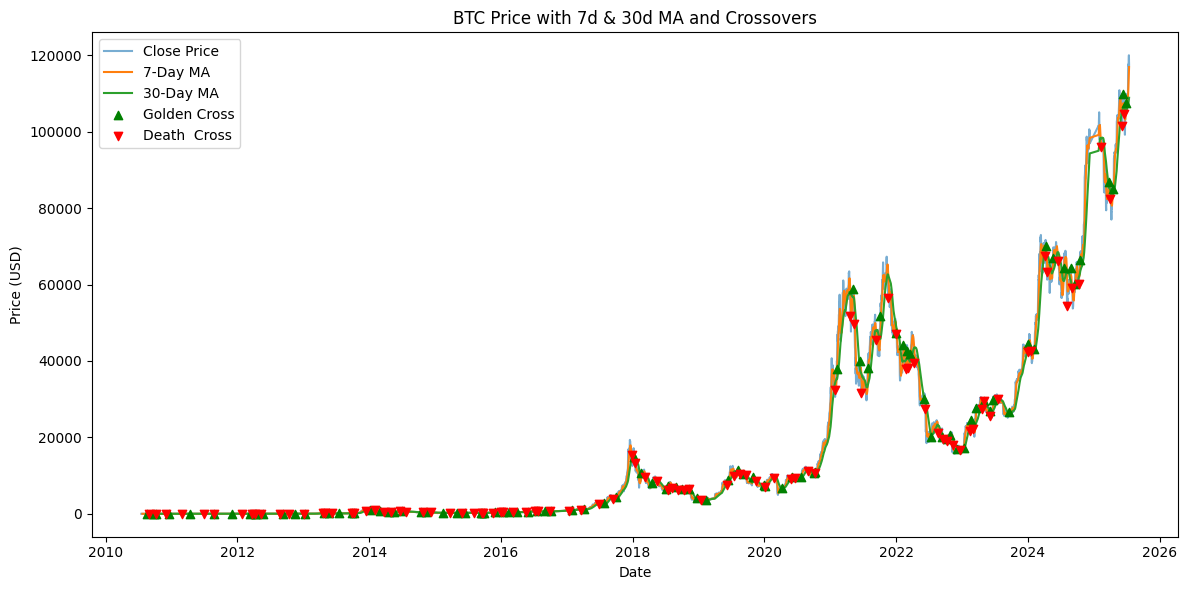

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature‑engineered data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)

# Filter for BTC
df_btc = df[df['Ticker']=='BTC'].copy()

# Ensure 30d MA exists
df_btc['30d ma'] = df_btc['Close'].rolling(30).mean()

# Compute the MA difference & signals
df_btc['ma_diff'] = df_btc['7d ma'] - df_btc['30d ma']
df_btc['signal']  = df_btc['ma_diff'].apply(lambda x: 1 if x>0 else -1)
df_btc['crossover'] = df_btc['signal'].diff()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_btc['Date'], df_btc['Close'],    label='Close Price', alpha=0.6)
plt.plot(df_btc['Date'], df_btc['7d ma'],    label='7‑Day MA')
plt.plot(df_btc['Date'], df_btc['30d ma'],   label='30‑Day MA')

# Golden crosses (crossover == 2)
golden = df_btc[df_btc['crossover']== 2]
plt.scatter(golden['Date'], golden['Close'],
            color='green', marker='^', label='Golden Cross', zorder=5)

# Death crosses (crossover == -2)
death = df_btc[df_btc['crossover']== -2]
plt.scatter(death['Date'], death['Close'],
            color='red',   marker='v', label='Death  Cross', zorder=5)

plt.title('BTC Price with 7d & 30d MA and Crossovers')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

## Question 5: Price Range vs. Absolute Daily % Change  
How does the intraday price range relate to the magnitude of Bitcoin’s daily returns?

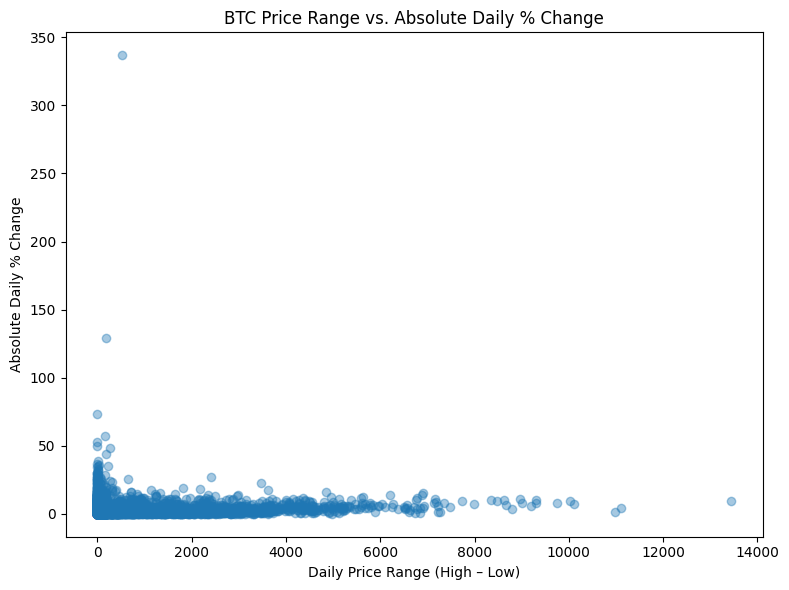

Pearson correlation: 0.0491


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature‑engineered data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)

# Filter for BTC and drop NaNs
df_btc = df[df['Ticker']=='BTC'].dropna(subset=['Price range','Daily % change'])

# Compute absolute daily % change
df_btc['Abs % change'] = df_btc['Daily % change'].abs()

# Scatter plot: Price Range vs. Absolute % Change
plt.figure(figsize=(8,6))
plt.scatter(df_btc['Price range'], df_btc['Abs % change'], alpha=0.4)
plt.title('BTC Price Range vs. Absolute Daily % Change')
plt.xlabel('Daily Price Range (High – Low)')
plt.ylabel('Absolute Daily % Change')
plt.tight_layout()
plt.show()

# (Optional) Quantify correlation
corr = df_btc['Price range'].corr(df_btc['Abs % change'])
print(f"Pearson correlation: {corr:.4f}")

## Question 6: Drawdown Analysis  
What are the largest peak‑to‑trough drawdowns in Bitcoin’s price history, and how long did each drawdown period last?

Top 5 drawdowns:
            Date   Drawdown
30993 2011-11-18 -93.074324
30995 2011-11-20 -92.567568
30994 2011-11-19 -92.567568
30989 2011-11-14 -92.500000
30992 2011-11-17 -92.398649


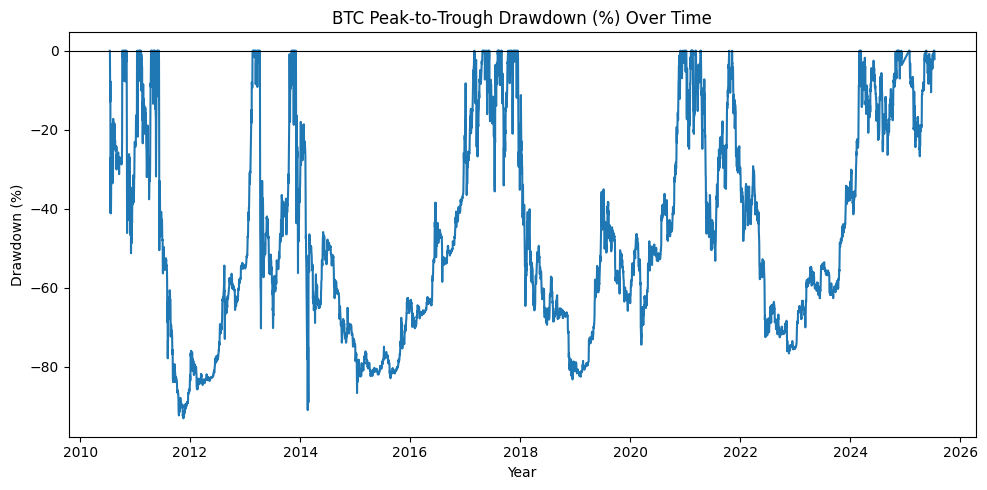

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load feature‑engineered data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)
df_btc = df[df['Ticker']=='BTC'].copy()

# Compute running maximum and drawdown
df_btc['RunningMax'] = df_btc['Close'].cummax()
df_btc['Drawdown']  = (df_btc['Close'] - df_btc['RunningMax']) / df_btc['RunningMax'] * 100

# Identify top 5 drawdowns
drawdowns = df_btc[['Date','Drawdown']].sort_values('Drawdown').head(5)
print("Top 5 drawdowns:")
print(drawdowns)

# Plot drawdown over time
plt.figure(figsize=(10,5))
plt.plot(df_btc['Date'], df_btc['Drawdown'])
plt.title('BTC Peak‑to‑Trough Drawdown (%) Over Time')
plt.xlabel('Year')
plt.ylabel('Drawdown (%)')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## Question 7: Seasonality Effects  
Are there systematic patterns in Bitcoin’s daily returns by day of week or day of month?

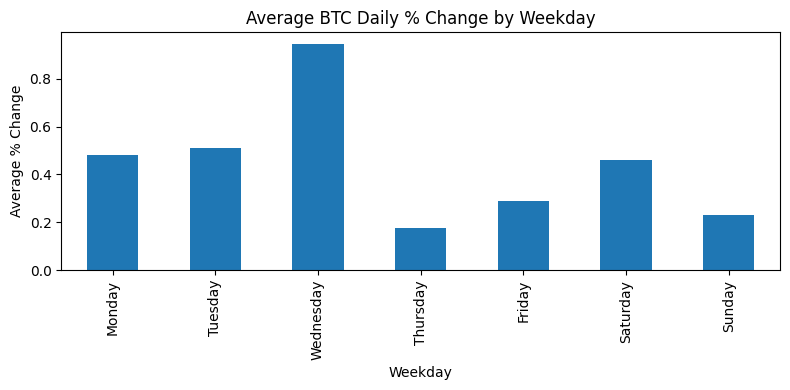

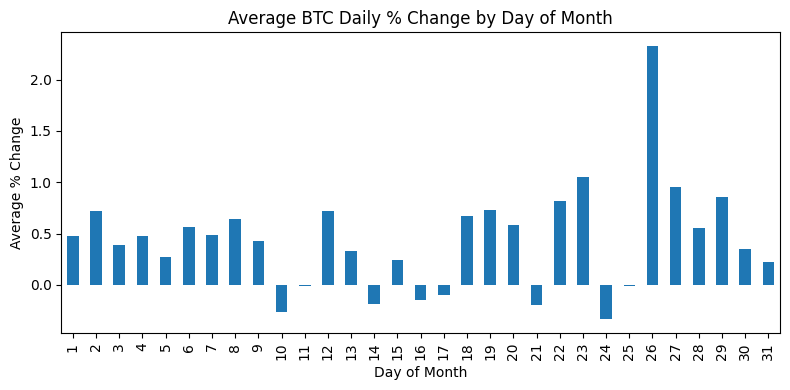

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load feature‐engineered data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)
df_btc = df[df['Ticker']=='BTC'].dropna(subset=['Daily % change'])

# Extract weekday and day-of-month
df_btc['Weekday']      = df_btc['Date'].dt.day_name()
df_btc['DayOfMonth']   = df_btc['Date'].dt.day

# 1) Average return by weekday
avg_wkday = df_btc.groupby('Weekday')['Daily % change'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# 2) Average return by day-of-month
avg_dom = df_btc.groupby('DayOfMonth')['Daily % change'].mean()

# Plot weekday seasonality
plt.figure(figsize=(8,4))
avg_wkday.plot(kind='bar')
plt.title('Average BTC Daily % Change by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average % Change')
plt.tight_layout()
plt.show()

# Plot day‑of‑month seasonality
plt.figure(figsize=(8,4))
avg_dom.plot(kind='bar')
plt.title('Average BTC Daily % Change by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average % Change')
plt.tight_layout()
plt.show()

## Question 8: High‑Volatility Regimes  
Can we classify days as “low” or “high” volatility based on the 7‑day rolling volatility, and how do average returns differ between these regimes?

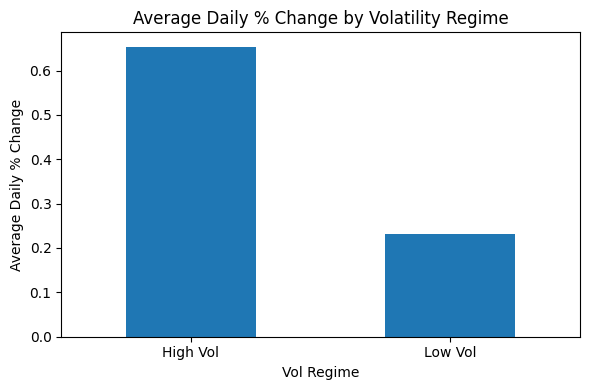

Median 7d Volatility: 2.7789
            Daily % change
Vol Regime                
High Vol          0.653393
Low Vol           0.232130


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load engineered data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)
btc = df[df['Ticker']=='BTC'].copy()

# Define regimes: high vol if 7d volatility above its median
median_vol = btc['7d volatility'].median()
btc['Vol Regime'] = btc['7d volatility'].apply(
    lambda x: 'High Vol' if x > median_vol else 'Low Vol'
)

# Compute average Daily % change by regime
avg_returns = btc.groupby('Vol Regime')['Daily % change'].mean()

# Bar chart of average returns
plt.figure(figsize=(6,4))
avg_returns.plot(kind='bar', rot=0)
plt.title('Average Daily % Change by Volatility Regime')
plt.ylabel('Average Daily % Change')
plt.tight_layout()
plt.show()

# Print numeric values
print("Median 7d Volatility:", round(median_vol,4))
print(avg_returns.to_frame())

## Question 9: Price Range Dynamics  
How does Bitcoin’s daily high–low range compare to its 7‑day and 30‑day moving averages of the range?

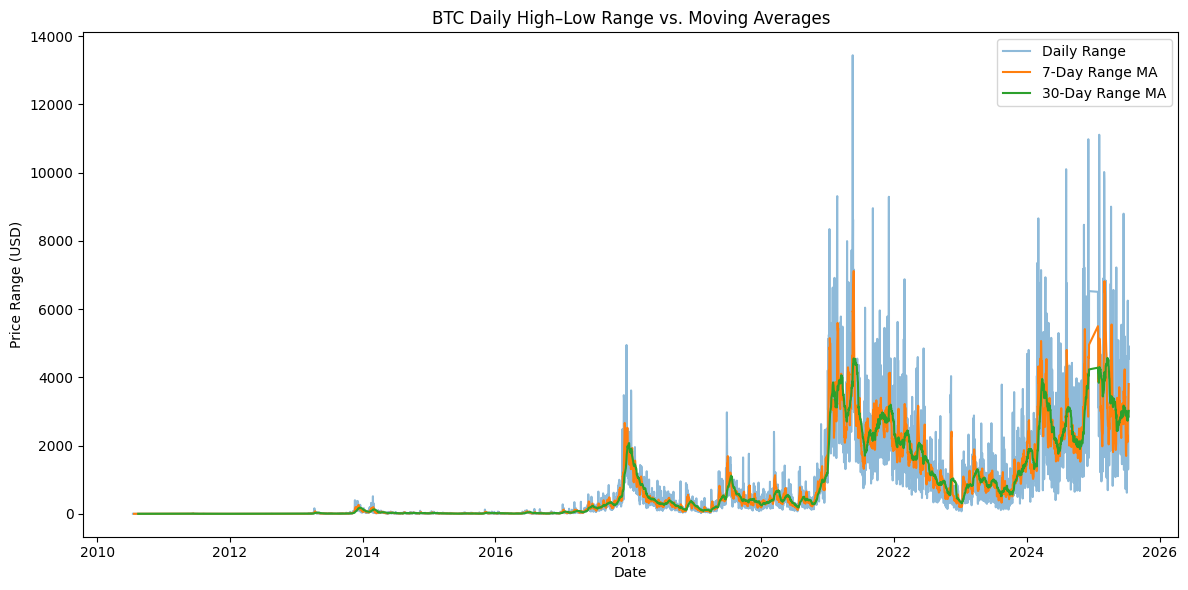

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)
btc = df[df['Ticker']=='BTC'].copy()

# Compute 7‑day and 30‑day MAs of the price range
btc['7d range MA']  = btc['Price range'].rolling(window=7).mean()
btc['30d range MA'] = btc['Price range'].rolling(window=30).mean()

# Plot price range and its moving averages
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], btc['Price range'],    label='Daily Range', alpha=0.5)
plt.plot(btc['Date'], btc['7d range MA'],    label='7‑Day Range MA')
plt.plot(btc['Date'], btc['30d range MA'],   label='30‑Day Range MA')
plt.title('BTC Daily High–Low Range vs. Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price Range (USD)')
plt.legend()
plt.tight_layout()
plt.show()

## Question 10: Event‑Based Spikes  
Do key Bitcoin events—such as halvings—align with significant moves in price or volatility?

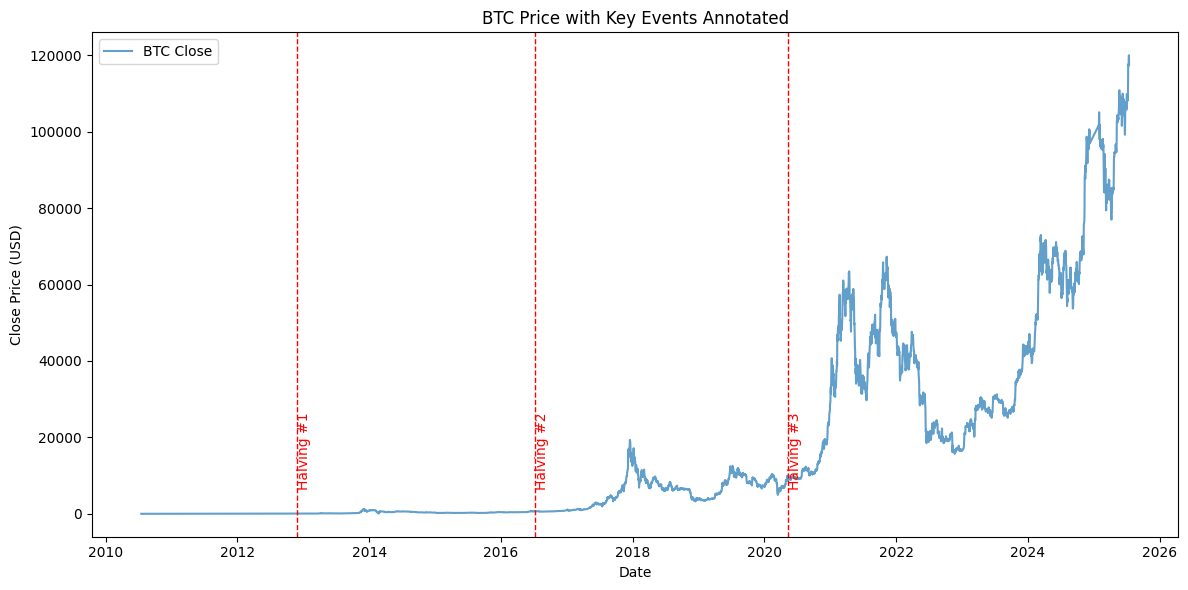

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('crypto_features.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker','Date']).reset_index(drop=True)
btc = df[df['Ticker']=='BTC'].copy()

# Define key events (example: Bitcoin halving dates)
events = [
    {'date': '2012-11-28', 'label': 'Halving #1'},
    {'date': '2016-07-09', 'label': 'Halving #2'},
    {'date': '2020-05-11', 'label': 'Halving #3'},
    # Add more events here...
]
# Convert to Timestamp
for ev in events:
    ev['ts'] = pd.to_datetime(ev['date'])

# Plot price
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], btc['Close'], label='BTC Close', alpha=0.7)

# Annotate events
for ev in events:
    plt.axvline(ev['ts'], color='red', linestyle='--', linewidth=1)
    plt.text(ev['ts'], 
             plt.ylim()[1]*0.05,  # 5% up from bottom
             ev['label'], 
             rotation=90, 
             verticalalignment='bottom',
             color='red')

plt.title('BTC Price with Key Events Annotated')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()